In [22]:
import pandas as pd
import numpy as np
from openbabel import openbabel as ob
from openbabel import pybel as pb
from molvs import standardize_smiles

In [2]:
train = pd.read_csv("Task/train.csv", index_col=0)
train["Smiles"].replace("se", "Se", inplace=True, regex=True)
test = pd.read_csv("Task/test.csv", index_col=0)

Possible preprocessing steps:
<ul>
    <li>Standardization</li>
    <li>Desalting</li>
    <li>Neutralization</li>
    <li>Tautomer normalization</li>
    <li>Removing of duplicates</li>
</ul>

In [3]:
# they are all on a large distance from the core
# provided for the reference
ions = [".[Na+]", ".[Ca+2]", ".[Br-]", ".[Cl-]", ".[Zn+2]", ".[K+]",
        ".[I-]", ".[Li+]", ".[Li]", ".[Sr+2]", ".[Ag+]", ".[Mg+2]"]

remove_atoms = [
    "Ag", # there is no pure Ag except for ionic form
    "Al", # 1 big structure in train, False, no structures in test
    "As", # 2 structures in train with [As], all False, 3 structures in test.                     *
    "B",  # 13 structures in train, all False, 6 structures in test                               *
    "Ca", # there is no pure Ca except for ionic form
    "K",  # there is no pure K except for ionic form
    "Li", # there is no pure Li except for ionic form
    "Mg", # there is no pure Mg except for ionic form
    "Na", # there is no pure Na except for ionic form
    "Se", # 2 structures in train with [Se], all False, no structures in test
          # 1 structure in train with [se], True
    "Si", # 2 structures in train with [Si] (one garbage), all False, no structures in test
    "Sr", # there is no pure Sr except for ionic form
    "Zn", # 2 structures in train with [Zn], all False, 1 structure in test                       *
]

other_atoms = ["Br", "C", "Cl", "F", "H", "I", "N", "O", "P", "S"]

# we remove shorter (or equal) fragments with possible exceptions

# special cases

special_train = [
    1172, # garbage ?
    2569, # [I-][K+]
    
]
special_test = [
    1101, # salt is larger than the core
]

In [4]:
def remove_salt(smile):
    tokens = smile.split(".")
    max_token = ""
    for token in tokens:
        if len(token) > len(max_token):
            max_token = token
    return max_token

In [5]:
train["Smiles"] = train["Smiles"].apply(remove_salt)
test["Smiles"] = test["Smiles"].apply(remove_salt)

In [6]:
atoms = remove_atoms[:]
atoms[atoms.index("B")] = "B[^r]"
train = train.drop(
    train[train["Smiles"].str.contains("|".join(atoms))].index
).reset_index(drop=True)

In [7]:
# we need to neutralize structures, espicially those, 
# from which we've removed the salts
# https://baoilleach.blogspot.com/2019/12/no-charge-simple-approach-to.html

pat_v3 = ob.OBSmartsPattern()
pat_v3.Init("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")

def neutralize(mol):
    """Neutralize charges of +1 or -1"""
    mol = mol.OBMol
    pat_v3.Match(mol)
    for match in pat_v3.GetMapList():
        atom = mol.GetAtom(match[0])
        chg = atom.GetFormalCharge()
        hcount = atom.GetImplicitHCount()
        atom.SetFormalCharge(0)
        atom.SetImplicitHCount(hcount - chg)
    return pb.Molecule(mol)

In [8]:
train["Smiles"][12]

'Nc1nc(O)c2c(n1)NCC(CNc1ccc(C(=O)N[C@@H](CCC(=O)[O-])C(=O)[O-])cc1)N2C=O'

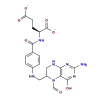

In [9]:
pb.readstring('smi', train["Smiles"][12])

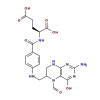

In [10]:
neutralize(pb.readstring('smi', train["Smiles"][12]))

In [11]:
train["Smiles"] = train["Smiles"].apply(lambda x: neutralize(pb.readstring("smi", x)).write().strip())
test["Smiles"] = test["Smiles"].apply(lambda x: neutralize(pb.readstring("smi", x)).write().strip())

In [23]:
# no effect on duplicates
train["Smiles"] = train["Smiles"].apply(standardize_smiles)
test["Smiles"] = test["Smiles"].apply(standardize_smiles)

In [24]:
train = train.drop_duplicates(subset=['Smiles']).reset_index(drop=True)

In [25]:
train

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False
...,...,...
5354,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc2c(n1)N(C1CCC1)C(...,False
5355,O=C(Oc1ccc([N+](=O)[O-])cc1)N1CCC(C(O)(c2ccc3c...,False
5356,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Br)c1,False
5357,Oc1cccc2cccnc12,False


In [26]:
diff_df = pd.merge(test, train, how='left', on="Smiles", indicator='Exists')
diff_df = diff_df[diff_df["Exists"]=="both"]

In [27]:
diff_df

,Smiles,Active,Exists
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,True,both
27,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,False,both
41,COc1ccnc(C[S+]([O-])c2nc3cc(OC(F)F)ccc3[nH]2)c1OC,True,both
54,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...,False,both
60,CN(C)C(=O)Oc1cc(OC(=O)N(C)C)cc(C(O)CNC(C)(C)C)c1,False,both
...,...,...,...
1544,CCCCCCOc1nsnc1C1=CCCN(C)C1,False,both
1547,NC[C@@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@@H](O[C@...,False,both
1583,N/C(=N\C(=O)c1nc(Cl)c(N)nc1N)NCc1ccccc1,False,both
1593,Oc1cccc2cccnc12,False,both


In [28]:
diff_df[diff_df["Active"] == True]

,Smiles,Active,Exists
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,True,both
41,COc1ccnc(C[S+]([O-])c2nc3cc(OC(F)F)ccc3[nH]2)c1OC,True,both
453,CCN(CC)C(=S)S,True,both
1173,Nc1ccc2cc3ccc(N)cc3nc2c1,True,both


In [37]:
# indices in test which are True
print(list(diff_df[diff_df["Active"] == True].index))

[2, 41, 453, 1173]


In [29]:
diff_df[diff_df["Active"] == False]

,Smiles,Active,Exists
27,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,False,both
54,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...,False,both
60,CN(C)C(=O)Oc1cc(OC(=O)N(C)C)cc(C(O)CNC(C)(C)C)c1,False,both
167,Cn1c(=O)cc(N2CCC[C@@H](N)C2)n(Cc2ccccc2C#N)c1=O,False,both
177,CN(C)CC(c1ccc(O)cc1)C1(O)CCCCC1,False,both
...,...,...,...
1544,CCCCCCOc1nsnc1C1=CCCN(C)C1,False,both
1547,NC[C@@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@@H](O[C@...,False,both
1583,N/C(=N\C(=O)c1nc(Cl)c(N)nc1N)NCc1ccccc1,False,both
1593,Oc1cccc2cccnc12,False,both


In [38]:
# indices in test which are False
print(list(diff_df[diff_df["Active"] == False].index))

[27, 54, 60, 167, 177, 187, 213, 220, 239, 255, 256, 260, 272, 296, 358, 366, 372, 386, 389, 402, 427, 447, 455, 487, 489, 492, 497, 521, 529, 531, 539, 542, 545, 564, 572, 590, 654, 662, 695, 698, 703, 740, 754, 779, 793, 805, 824, 832, 852, 853, 871, 888, 922, 951, 954, 961, 966, 974, 979, 990, 992, 1047, 1053, 1057, 1082, 1099, 1101, 1114, 1135, 1154, 1156, 1159, 1191, 1192, 1209, 1230, 1233, 1242, 1249, 1355, 1358, 1367, 1389, 1396, 1411, 1425, 1495, 1501, 1522, 1523, 1542, 1544, 1547, 1583, 1593, 1607]


In [30]:
train.to_csv("Clean/train.csv")
test.to_csv("Clean/test.csv")